In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import random as rand
import numpy as np
import pandas as pd
import matplotlib as plt
import math

#import shap
#import lifelines
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import joblib

from IPython.display import Image

from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
import seaborn

In [ ]:
%cd drive/My Drive/Meat_Microsimulation/

/content/drive/My Drive/Meat_Microsimulation


In [ ]:
years = {2017: '_J.XPT', 2015: '_I.XPT', 2013: '_H.XPT'}

datasets = {}
for year in years.keys():
  datasets[year] = {}

  datasets[year]['Dem_data'] = pd.read_sas('Data/'+str(year)+ '/DEMO' + years[year])
  datasets[year]['Alcohol_data'] = pd.read_sas('Data/'+str(year)+ '/ALQ' + years[year])
  datasets[year]['Smoking_data'] = pd.read_sas('Data/'+str(year)+ '/SMQ' + years[year])
  datasets[year]['BMI_data'] = pd.read_sas('Data/'+str(year)+ '/BMX' + years[year])
  datasets[year]['SBP_data'] = pd.read_sas('Data/'+str(year)+ '/BPX' + years[year])
  datasets[year]['HDL_data'] = pd.read_sas('Data/'+str(year)+ '/HDL' + years[year])
  datasets[year]['TChol_data'] = pd.read_sas('Data/'+str(year)+ '/TCHOL' + years[year])
  datasets[year]['BPQ_data'] = pd.read_sas('Data/'+str(year)+ '/BPQ' + years[year])
  datasets[year]['MV_data'] = pd.read_sas('Data/'+str(year)+ '/DSQTOT' + years[year])
  datasets[year]['Diabetes_data'] = pd.read_sas('Data/'+str(year)+ '/DIQ' + years[year])
  datasets[year]['Blood_Glucose'] = pd.read_sas('Data/'+str(year)+ '/GLU' + years[year])
  datasets[year]['MQ_data'] = pd.read_sas('Data/'+str(year)+ '/MCQ' + years[year])
  datasets[year]['Rep_data'] = pd.read_sas('Data/'+str(year)+ '/RHQ' + years[year])
  datasets[year]['Asp_data'] = pd.read_sas('Data/'+str(year)+ '/RXQASA' + years[year])
  datasets[year]['PA_data'] = pd.read_sas('Data/'+str(year)+ '/PAQ' + years[year])

In [ ]:
for year in years.keys():
  dem_data = datasets[year]['Dem_data']
  age_filter = (dem_data['RIDAGEYR'] > 17)   ## only want Adults in the simulation
  dem_data = dem_data.loc[age_filter]
  datasets[year]['Dem_data']  = dem_data[['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'DMDEDUC2', 'DMDEDUC3', 'INDHHIN2', 'WTINT2YR']]

  datasets[year]['BMI_data'] = datasets[year]['BMI_data'][['SEQN', 'BMXHT', 'BMXWT']]
  datasets[year]['SBP_data'] = datasets[year]['SBP_data'][['SEQN','BPXSY1']]
  datasets[year]['HDL_data'] = datasets[year]['HDL_data'][['SEQN','LBDHDD']]
  datasets[year]['TChol_data'] = datasets[year]['TChol_data'][['SEQN', 'LBXTC']]
  datasets[year]['Smoking_data'] = datasets[year]['Smoking_data'][['SEQN', 'SMQ040', 'SMD030', 'SMD650', ]]
  datasets[year]['BPQ_data'] = datasets[year]['BPQ_data'][['SEQN', 'BPQ040A']]
  datasets[year]['MV_data'] = datasets[year]['MV_data'][['SEQN', 'DSD010']]
  datasets[year]['Diabetes_data'] = datasets[year]['Diabetes_data'][['SEQN', 'DIQ010']]
  datasets[year]['Blood_Glucose'] = datasets[year]['Blood_Glucose'][['SEQN', 'LBXGLU']]
  datasets[year]['MQ_data'] = datasets[year]['MQ_data'][['SEQN', 'MCQ300C','MCQ160A','MCQ160B', 'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ230A', 'MCQ230B']]
  datasets[year]['Rep_data'] = datasets[year]['Rep_data'][['SEQN', 'RHQ554']]
  datasets[year]['Asp_data'] = datasets[year]['Asp_data'][['SEQN', 'RXQ515', 'RXQ520']]
  datasets[year]['PA_data'] =  datasets[year]['PA_data'][['SEQN','PAD680', 'PAD615', 'PAD630', 'PAD645', 'PAD660', 'PAD675']]

  if year == 2017:
    datasets[year]['Alcohol_data'] = datasets[year]['Alcohol_data'][['SEQN', 'ALQ130', 'ALQ111', 'ALQ121']]
  else:
    datasets[year]['Alcohol_data'] = datasets[year]['Alcohol_data'][['SEQN', 'ALQ130', 'ALQ101']]

In [ ]:
combined_data = {}

for key in datasets[year].keys():
  dfs = []
  for year in 2017, 2015, 2013:
    dfs.append(datasets[year][key])

  combined_data[key] =pd.concat(dfs, axis = 0 )

In [ ]:
combined_data_list = list(combined_data.items())
df = combined_data_list[0][1]

for i in range(len(combined_data_list)-1):
  df = pd.merge(df, combined_data_list[i+1][1], how='left', on='SEQN')

In [ ]:
df.head()

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH3,DMDEDUC2,DMDEDUC3,INDHHIN2,WTINT2YR,ALQ130,ALQ111,...,MCQ230B,RHQ554,RXQ515,RXQ520,PAD680,PAD615,PAD630,PAD645,PAD660,PAD675
0,93705.0,2.0,66.0,4.0,2.0,NaN,3.0,8614.571172,1.0,1.0,...,NaN,1.0,2.0,NaN,300.0,NaN,NaN,NaN,NaN,60.0
1,93706.0,1.0,18.0,6.0,NaN,15.0,NaN,8548.632619,NaN,2.0,...,NaN,NaN,NaN,NaN,240.0,NaN,NaN,45.0,NaN,30.0
2,93708.0,2.0,66.0,6.0,1.0,NaN,6.0,13329.450589,NaN,2.0,...,NaN,NaN,NaN,2.0,120.0,NaN,NaN,NaN,NaN,30.0
3,93709.0,2.0,75.0,4.0,4.0,NaN,2.0,12043.388271,NaN,NaN,...,NaN,NaN,1.0,NaN,600.0,NaN,180.0,NaN,NaN,NaN
4,93711.0,1.0,56.0,6.0,5.0,NaN,15.0,11178.260106,1.0,1.0,...,NaN,NaN,1.0,NaN,420.0,NaN,NaN,60.0,60.0,30.0


In [ ]:
df = df.set_index('SEQN')

In [ ]:
years_of_education_dict = {1: 8, 2: 10, 3: 12, 4: 14, 5: 16, 7: 0, 9: 0}
youth_education_variables = {13: 12, 14: 12, 15: 13, 55: 1, 66: 5, 77: 0, 99: 0}
Income_variables = {12:5, 13:4, 14:11, 15:12, 77: 9, 99:9}
Smoker_variables = {1:1, 2:1, 3:0, 7:0, 9:0, np.nan: 0}
Parental_hist_variables = {1:1, 2:0, 9:0, 7:0, np.nan: 0}

#df['INDHHIN2'] = df['INDHHIN2'].fillna(value=9)   ## Relace missing values with approximate average household income
df = df.replace({'DMDEDUC2': years_of_education_dict})
df = df.replace({'DMDEDUC3': youth_education_variables})
df = df.replace({'INDHHIN2': Income_variables})
df = df.replace({'SMQ040': Smoker_variables})
df = df.replace({"MCQ300C": Parental_hist_variables})

In [ ]:
columns={"RIAGENDR": "Sex",
         "RIDAGEYR": "Age",
         "RIDRETH3": "Ethnicity",
         "DMDEDUC2":"Adult Years of Education",
         "DMDEDUC3":"Youth Years of Education",
         "INDHHIN2": "Annual Household Income",
         'WTINT2YR': 'Sample Weight',
         "BMXHT": "Height",
         "BMXWT":"Weight",
         "BPXSY1": "Systolic Blood Pressure",
         "LBDHDD": "HDL Cholesterol",
          "LBXTC": "Total Cholesterol",
         "SMQ040": "Smoker",
         "MCQ300C": "Parental Diabetes History",
         "DIQ010": "Diabetes",
         "LBXGLU": "Blood Glucose"
         }

In [ ]:
df = df.rename(columns=columns)

In [ ]:
df['Adult Years of Education'] = df['Adult Years of Education'].fillna(df['Youth Years of Education'])  ## The missing data in theh adult education column corresponds to those aged 18 or 19
df.pop('Youth Years of Education')
df = df.rename(columns = {'Adult Years of Education': 'Years of Education'})

In [ ]:
df_base = df

In [ ]:
#variables_to_train = ['Sex', 'Age', 'Ethnicity','Height', 'Weight',  'Years of Education','Annual Household Income', 'Smoker', 'Systolic Blood Pressure', 'HDL Cholesterol' ,'Total Cholesterol', 'Parental Diabetes History', 'Diabetes', 'Blood Glucose']
variables_to_train = ['Sex', 'Age', 'Ethnicity', 'Years of Education', 'Annual Household Income', 'Height', 'Weight','HDL Cholesterol']
df = df_base[variables_to_train]

In [ ]:
ids_with_missing_data = df[df[['Height', 'Weight','HDL Cholesterol']].isnull().any(axis=1)].index.values.tolist()

In [ ]:
len(ids_with_missing_data)

1961

In [ ]:
df = df[['Age','Sex', 'Height', 'Weight', 'HDL Cholesterol']]

In [ ]:
df_to_train = df[~df.index.isin(ids_with_missing_data)]

In [ ]:
ids_to_train = df_to_train.index.values
df_to_pred = df[~df.index.isin(ids_to_train)]

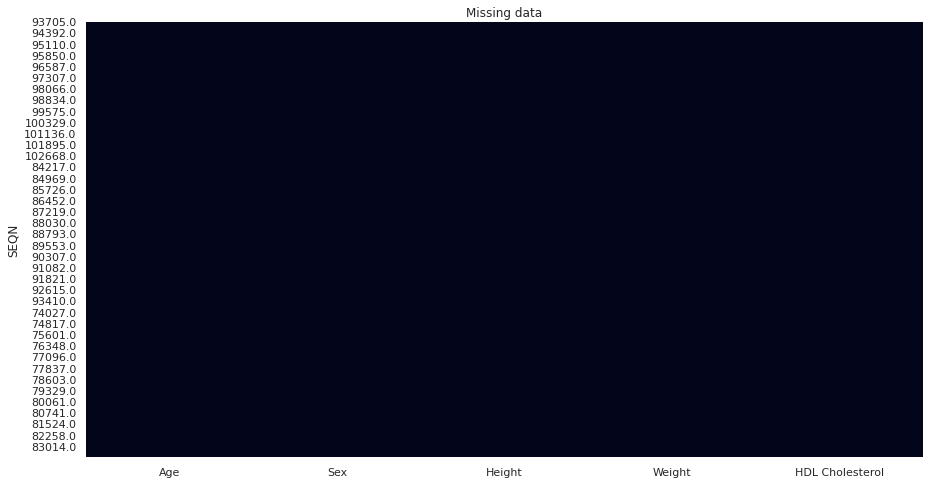

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df_to_train.isnull(), cbar=False)
plt.title("Missing data")
#plt.savefig('Plots/Missing_data_2017.png', dpi=300)
plt.show()

In [ ]:
def calculate_BMI(row):
  BMI = row['Weight']/(row['Height']/100)**2
  return BMI

In [ ]:
df_to_train

,Age,Sex,HDL Cholesterol,BMI
SEQN,,,,
93705.0,66.0,2.0,60.0,31.725268
93706.0,18.0,1.0,47.0,21.476821
93708.0,66.0,2.0,88.0,23.714497
93709.0,75.0,2.0,65.0,38.894128
93711.0,56.0,1.0,72.0,21.337009
...,...,...,...,...
83721.0,52.0,1.0,55.0,25.606801
83723.0,61.0,1.0,49.0,33.054008
83724.0,80.0,1.0,51.0,24.890238


In [ ]:
df_to_train['BMI'] = df_to_train.apply(lambda row: calculate_BMI(row), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_to_train = df_to_train.drop(['Height', 'Weight'], axis=1)

In [ ]:
df_to_train

,Age,Sex,HDL Cholesterol,BMI
SEQN,,,,
93705.0,66.0,2.0,60.0,31.725268
93706.0,18.0,1.0,47.0,21.476821
93708.0,66.0,2.0,88.0,23.714497
93709.0,75.0,2.0,65.0,38.894128
93711.0,56.0,1.0,72.0,21.337009
...,...,...,...,...
83721.0,52.0,1.0,55.0,25.606801
83723.0,61.0,1.0,49.0,33.054008
83724.0,80.0,1.0,51.0,24.890238


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.2)

In [ ]:
y_train

SEQN
98714.0     215.0
97088.0     131.0
100624.0    143.0
79060.0     133.0
75592.0     224.0
            ...  
82140.0     130.0
78000.0     223.0
96349.0     142.0
87303.0     158.0
86322.0     237.0
Name: Total Cholesterol, Length: 12800, dtype: float64

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
X_train = np.array(X_train).reshape(-1,1)
X_val = np.array(X_val).reshape(-1,1)

y_train = np.array(y_train).reshape(-1,1)
y_val = np.array(y_val).reshape(-1,1)

In [ ]:
reg = LinearRegression().fit(X_train, y_train)

0.23471096002270897

In [ ]:
mape = np.mean(np.abs((y_val - reg.predict(y_val)) / np.abs(y_val)))

print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Mean Absolute Percentage Error (MAPE): 30.89
Accuracy: 69.11


In [ ]:
y_val_pred = reg.predict(y_val)

## Random Forest Regression

In [ ]:
variables_to_train = ['Age','Sex', 'Height', 'Weight']

In [ ]:
y = df_to_train['HDL Cholesterol']
X = df_to_train[variables_to_train]


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.25)

In [ ]:
def fit_rf_model(**params):
    rf_reg = RandomForestRegressor(**params)  #random state = 10
    rf_reg.fit(X_train, y_train)

    y_train_best = rf_reg.predict(X_train)
    y_val_best = rf_reg.predict(X_val)

    print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_val, y_val_best))
    print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_val, y_val_best))
    print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_val, y_val_best)))

    y_val_array  = np.array(y_val.T)[0]
    mape = np.mean(np.abs((y_val_array - y_val_best) / np.abs(y_val_array)))
    accuracy = round(100*(1 - mape), 2)
    print('Accuracy:', accuracy)

    return rf_reg, accuracy

In [ ]:
def grid_search(param_grid):

  models = {}

  lists = param_grid.values()
  param_combinations = list(itertools.product(*lists))

  for i, params in enumerate(param_combinations, 1):
    # fill param dict with params
      param_dict = {}
      for param_index, param_name in enumerate(param_grid):
          param_dict[param_name] = params[param_index]
          rf_reg, accuracy = fit_rf_model(**param_dict)
          models[i] = {'Model': rf_reg, 'Accuracy': accuracy}

  return models

In [ ]:

param_grid = {
    'bootstrap': [True],
    'max_depth': [7,8,9,10],
    'max_features': [1,2,3],
    'min_samples_leaf': [1,2,3,4],
    'min_samples_split': [8,9],
    'n_estimators': [400, 500],
    #'class_weight':'balanced'
}

In [ ]:
models = grid_search(param_grid)

In [ ]:
params = {
    'bootstrap': [True],
    'max_depth': 7,
    'max_features': 1,
    'min_samples_leaf': 4,
    'min_samples_split': 8,
    'n_estimators': 500,
    #'class_weight':'balanced'
}

In [ ]:
rf_reg = RandomForestRegressor(**params)  #random state = 10
rf_reg.fit(X_train, y_train)



RandomForestRegressor(bootstrap=[True], max_depth=7, max_features=1,
                      min_samples_leaf=4, min_samples_split=8,
                      n_estimators=500)

In [ ]:
y_train_best = rf_reg.predict(X_train)
y_val_best = rf_reg.predict(X_val)


print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_val, y_val_best))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_val, y_val_best))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_val, y_val_best)))

y_val_array  = np.array(y_val.T)[0]
mape = np.mean(np.abs((y_val_array - y_val_best) / np.abs(y_val_array)))

print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Mean Absolute Error (MAE): 12.016796202032465
Mean Squared Error (MSE): 258.5884048559895
Root Mean Squared Error (RMSE): 16.080684216039735
Mean Absolute Percentage Error (MAPE): 6.65
Accuracy: 93.35


In [ ]:
scores = cross_val_score(rf_reg, X_val, y_val, cv=10, scoring='neg_mean_absolute_percentage_error')

In [ ]:
params = {
    'bootstrap': [True],
    'max_depth': 6,
    'max_features': 4,
    'min_samples_leaf': 5,
    'min_samples_split': 5,
    'n_estimators': 500,
#    'max_samples' : 2000
    #'class_weight':'balanced'
}

In [ ]:
for _ in range(5):
  X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.25)
  rf_reg = RandomForestRegressor(**params)  #random state = 10
  rf_reg.fit(X_train, y_train)

  y_train_best = rf_reg.predict(X_train)
  y_train_array  = np.array(y_train.T)[0]

  mape_train = np.mean(np.abs((y_train_array - y_train_best) / np.abs(y_train_array)))
  accuracy_train = round(100*(1 - mape_train), 2)

  print('Train Accuracy:', accuracy_train)

  y_val_best = rf_reg.predict(X_val)
  y_val_array  = np.array(y_val.T)[0]

  mape_val = np.mean(np.abs((y_val_array - y_val_best) / np.abs(y_val_array)))
  accuracy_val = round(100*(1 - mape_val), 2)

  #print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
  print('Val Accuracy:', accuracy_val)
  print('\n')
  if accuracy_val > 80 and accuracy_train > 80:
     break

Train Accuracy: 38.84
Val Accuracy: 80.29


Train Accuracy: 59.44
Val Accuracy: 66.85


Train Accuracy: 86.63
Val Accuracy: 85.78




In [ ]:
plt.rcParams["figure.figsize"] = (20,3)

In [ ]:
rf_reg.predict(np.array([40,1,80]).reshape(1,-1))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


array([120.06041022])

In [ ]:
rf_reg.predict(X_val)

array([58.99206974, 50.55738994, 40.13401301, ..., 55.8650493 ,
       55.39483257, 52.73497651])

In [ ]:
y_val

SEQN
83065.0     55.0
101335.0    66.0
83519.0     45.0
100251.0    58.0
88503.0     66.0
            ... 
81582.0     62.0
90071.0     40.0
92839.0     48.0
93778.0     48.0
101097.0    44.0
Name: HDL Cholesterol, Length: 4000, dtype: float64

In [ ]:
X_val['Predictions'] = rf_reg.predict(X_val)

In [ ]:
X_train['Predictions'] = rf_reg.predict(X_train)

In [ ]:
X_val.sort_values(by=['Age'])

,Age,Sex,Height,Weight,Predictions
SEQN,,,,,
94305.0,18.0,2.0,152.2,60.4,55.910473
95874.0,18.0,2.0,160.4,84.9,52.639110
93938.0,18.0,2.0,163.2,63.1,56.613764
83331.0,18.0,1.0,165.0,59.5,52.756835
100260.0,18.0,2.0,154.5,80.0,49.606973
...,...,...,...,...,...
89015.0,80.0,1.0,178.8,90.8,49.462100
87998.0,80.0,2.0,163.9,72.9,61.094391
74313.0,80.0,2.0,160.6,48.8,72.121830


<Figure size 1080x576 with 0 Axes>

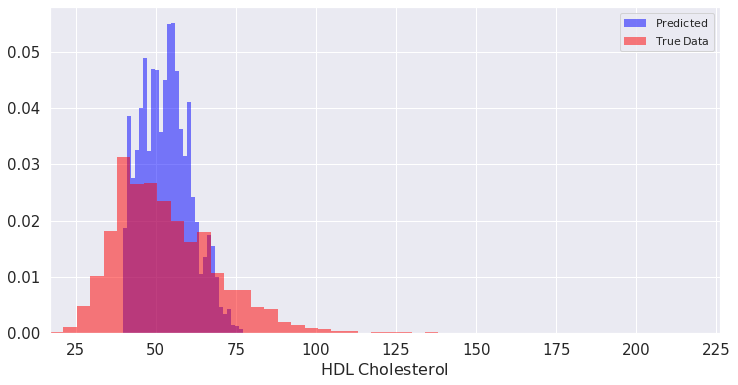

In [ ]:
plt.tight_layout()
plt.figure(figsize=(12,6))
plt.hist(np.array(X_val['Predictions']), bins = 30, color='blue', alpha=0.5, lw=0 ,density=True, label = '$\mathrm{Predicted}$')
plt.hist(np.array(y_val), bins = 50, color='red', alpha=0.5, lw=0 ,density=True, label = '$\mathrm{True \: Data}$')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(min(y_val), max(y_val))
plt.legend()

#plt.title('$\mathrm{Adult \; systolic \; blood \; pressure \; distribution}$', fontsize=20)
plt.xlabel("$\mathrm{HDL \; Cholesterol}$" , fontsize=16)
plt.show()

In [ ]:
joblib.dump(rf_reg, "Random_Forests/HDL_Chol_RF.joblib")

['Random_Forests/HDL_Chol_RF.joblib']

In [ ]:
!pip install shap
import shap

     |████████████████████████████████| 564 kB 23.0 MB/s 


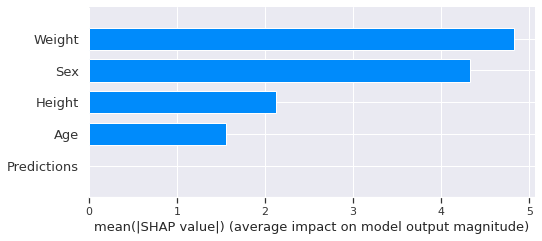

In [ ]:
shap_values = shap.TreeExplainer(rf_reg).shap_values(X_val)
shap.summary_plot(shap_values, X_val, plot_type="bar")

## Gaussian Process Regression

In [ ]:
import sklearn.gaussian_process as gp
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
y = df_to_train['Systolic Blood Pressure']
X = df_to_train[['Age', 'Sex', 'BMI']]

In [ ]:
groups.get_group('Systolic Blood Pressure')


KeyError: ignored

In [ ]:
groups = X.groupby('Sex')
for name, group in groups:
    plt.plot(group.Age, group.SBP, marker='o', linestyle='', markersize=5, label=name)

plt.legend()

AttributeError: ignored

In [ ]:
X.head(100)

,Age,BMI
SEQN,,
93709.0,75.0,38.894128
93721.0,60.0,35.882948
93722.0,60.0,23.764537
93726.0,67.0,31.126612
93746.0,25.0,24.750344
...,...,...
94041.0,60.0,22.464000
94044.0,34.0,21.768707
94047.0,45.0,35.571530


In [ ]:
# Age and BMI

for _ in range(1):
  X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.2)

  kernel = gp.kernels.RBF([1,1], (1e-2, 1e2))
  #kernel =gp.kernels.RBF([1,1])     #gp.kernels.ConstantKernel(10)*
  #kernel = gp.kernels.DotProduct(sigma_0=10, sigma_0_bounds=(0.001, 100.0))
  model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

  # X_train = np.array(X_male).reshape(-1,1)
  # X_val = np.array(X_val_m).reshape(-1,1)
  # y_train = np.array(y_male).reshape(-1,1)
  # y_val = np.array(y_val_male).reshape(-1,1)


  X_train = X_train.head(2000)
  y_train = y_train.head(2000)

  scaler = StandardScaler()
  scaler.fit(X_train)
  X_train = scaler.transform(X_train)

  model.fit(X_train, y_train)

  X_val = scaler.transform(X_val)

  y_val_best = model.predict(X_val)
  y_val_array  = np.array(y_val.T)[0]
  mape = np.mean(np.abs((y_val_array - y_val_best) / np.abs(y_val_array)))

  print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
  print('Accuracy:', round(100*(1 - mape), 2))

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Mean Absolute Percentage Error (MAPE): 15.86
Accuracy: 84.14


In [ ]:
model.predict(X_val)


array([121.77208796, 121.93365483, 119.99323633, ..., 108.17794872,
       122.17836847, 122.6288609 ])

In [ ]:
scaler.inverse_transform(X_val)

array([[45.        , 30.91309961],
       [78.        , 30.58416734],
       [61.        , 28.54926699],
       ...,
       [58.        , 30.49605926],
       [63.        , 30.65596507],
       [18.        , 20.59890243]])

In [ ]:
diff.shape[0]

1512

In [ ]:
diff

SEQN
96375.0     35.533946
93859.0    -16.395735
84754.0      5.510483
91686.0    -16.669949
100988.0   -18.240000
              ...    
96457.0     -5.733299
96625.0     -4.074538
94918.0      3.760000
90016.0     -6.239999
79304.0     -2.722023
Name: Systolic Blood Pressure, Length: 1512, dtype: float64

In [ ]:
diff

SEQN
96375.0     35.533946
93859.0    -16.395735
84754.0      5.510483
91686.0    -16.669949
100988.0   -18.240000
              ...    
96457.0     -5.733299
96625.0     -4.074538
94918.0      3.760000
90016.0     -6.239999
79304.0     -2.722023
Name: Systolic Blood Pressure, Length: 1512, dtype: float64

In [ ]:
diff = np.array(y_val-model.predict(X_val))/np.array(y_val)

In [ ]:
diff

array([-0.14879328, -0.03333606, -0.27652379, ...,  0.19270188,
       -0.174792  ,  0.13641647])

In [ ]:
#diff = np.array(y_val-model.predict(X_val))
count =0
for i in range(diff.shape[0]):
  if np.abs(diff[i])>0.1:
    count+=1

print(count/len(diff))

0.4612015018773467


In [ ]:
test_ex = np.array([0.934, 1.58]).reshape(1,-1)
model.predict(test_ex)

array([125.51593293])

In [ ]:
scaler.inverse_transform(X_val)

array([[80.        , 25.18522998],
       [73.        , 22.49043611],
       [70.        , 27.98367347],
       ...,
       [71.        , 33.44308504],
       [35.        , 34.57446809],
       [38.        , 26.47556312]])

In [ ]:
for _ in range(1):
  X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.2)
  X_male = X_train[X_train['Sex']==1]
  X_male = X_male['Age']
  male_ids = X_male.index.values
  y_male = y_train[y_train.index.isin(male_ids)]
  X_val_m = X_val[X_val['Sex']==1]
  X_val_m = X_val_m['Age']
  male_val_ids = X_val_m.index.values
  y_val_male = y_val[y_val.index.isin(male_val_ids)]



  kernel =gp.kernels.RBF(44)     #gp.kernels.ConstantKernel(10)*
  #kernel = gp.kernels.DotProduct(sigma_0=10, sigma_0_bounds=(0.001, 100.0))
  model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

  X_train = np.array(X_male).reshape(-1,1)
  X_val = np.array(X_val_m).reshape(-1,1)
  y_train = np.array(y_male).reshape(-1,1)
  y_val = np.array(y_val_male).reshape(-1,1)

  # scaler = StandardScaler()
  # scaler.fit(y_train)
  # y_train = scaler.transform(y_train)

  X_train = X_train[:3000]
  y_train = y_train[:3000]

  model.fit(X_train, y_train)


  y_val_best = model.predict(X_val)
  y_val_array  = np.array(y_val.T)[0]
  mape = np.mean(np.abs((y_val_array - y_val_best) / np.abs(y_val_array)))

  print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
  print('Accuracy:', round(100*(1 - mape), 2))




Mean Absolute Percentage Error (MAPE): 11.44
Accuracy: 88.56


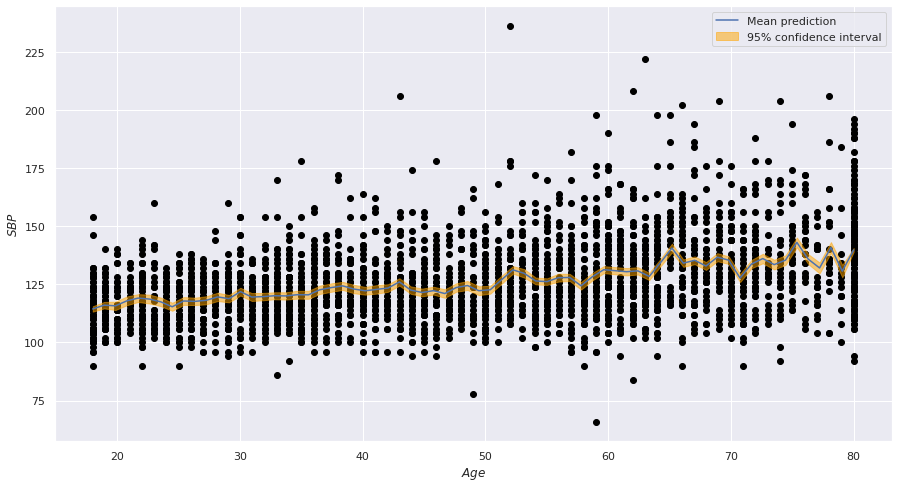

In [ ]:
ages = np.linspace(start=18, stop=80, num=68).reshape(-1, 1)
mean_prediction, std_prediction = model.predict(ages, return_std=True)
mean_prediction = mean_prediction.ravel()

plt.scatter(X_train[], y_train, color="black")
plt.plot(ages, mean_prediction, label="Mean prediction")
plt.fill_between(
    ages.ravel(),
    mean_prediction - 2 * std_prediction,
    mean_prediction + 2 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
    color='orange'
)
plt.legend()
plt.xlabel("$Age$")
plt.ylabel("$SBP$")
plt.show()


In [ ]:
mu, sigma = model.predict([[30]], return_std=True)
SBP = np.random.normal(mu,sigma)
print(SBP)

[[121.70109682]]


In [ ]:
scaler.mean_

array([48.1605    , 29.72566756])

In [ ]:
scaler.var_

array([339.47173975,  62.35514744])

In [ ]:
import joblib
import pickle

In [ ]:

filename = 'SBP_female_GRP.sav'
pickle.dump(model, open('Random_Forests/'+filename, 'wb'))

In [ ]:
model_2 = pickle.load(open('Random_Forests/'+filename, 'rb'))

In [ ]:
mu, sigma = model_2.predict([[30]], return_std=True)
SBP = np.random.normal(mu,sigma)
print(SBP)

[[122.55593535]]


In [ ]:
X_val_m = X_val[X_val['Sex']==1]

In [ ]:
X_val_m = X_val_m['Age']

In [ ]:
male_ids = X_val_m.index.values
y_val_male = y_val[y_val.index.isin(male_ids)]

In [ ]:
X_train = np.array(X_male).reshape(-1,1)
X_val = np.array(X_val_m).reshape(-1,1)

y_train = np.array(y_male).reshape(-1,1)
y_val = np.array(y_val_male).reshape(-1,1)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [ ]:
X_train = scaler.transform(X_train)

In [ ]:
X_train

array([[71.],
       [59.],
       [69.],
       ...,
       [69.],
       [32.],
       [28.]])

In [ ]:
X_train = X_train[:500]
y_train = y_train[:500]


In [ ]:
kernel = gp.kernels.ConstantKernel(1.0, (1e-1, 1e2)) * gp.kernels.RBF(10, (0.1, 300))
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20, alpha=0.1, normalize_y=True)

In [ ]:
model.fit(X_train, y_train)
params = model.kernel_.get_params()

In [ ]:
ages = np.linspace(start=18, stop=80, num=68).reshape(-1, 1)

In [ ]:
mean_prediction, std_prediction = model.predict(ages, return_std=True)

In [ ]:
plt.rcParams["figure.figsize"] = (20,3)

In [ ]:
mean_prediction = mean_prediction.ravel()

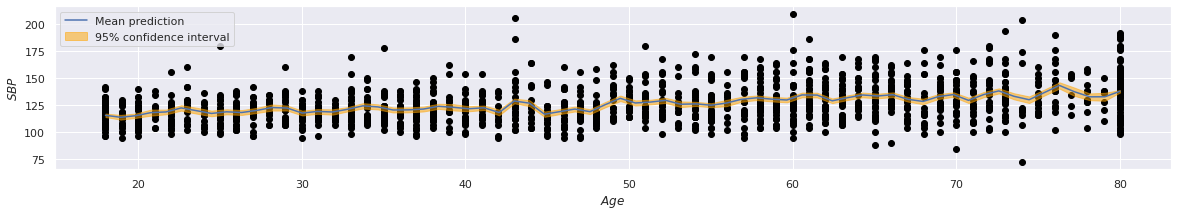

In [ ]:
plt.scatter(X_train, y_train, color="black")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 2 * std_prediction,
    mean_prediction + 2 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
    color='orange'
)
plt.legend()
plt.xlabel("$Age$")
plt.ylabel("$SBP$")
plt.show()


In [ ]:
y_val_best =  model.predict(X_val)

In [ ]:
model.kernel_

0.655**2 * RBF(length_scale=1)

In [ ]:
sample_Y = model.posterior_samples_f(X_val, full_cov=True, size=3)

AttributeError: ignored

In [ ]:
y_val

array([[134.],
       [120.],
       [126.],
       ...,
       [118.],
       [148.],
       [126.]])

In [ ]:
(y_val_best - y_val)[:100]

In [ ]:
MSE = ((y_val_best-y_val)**2).mean()

In [ ]:
print(MSE)

298.40215482834867


In [ ]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_val, y_val_best))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_val, y_val_best))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_val, y_val_best)))

Mean Absolute Error (MAE): 13.033803271647148
Mean Squared Error (MSE): 298.40215482834867
Root Mean Squared Error (RMSE): 17.274320676320347


In [ ]:
y_val_array  = np.array(y_val.T)[0]
mape = np.mean(np.abs((y_val_array - y_val_best) / np.abs(y_val_array)))

print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2))
print('Accuracy:', round(100*(1 - mape), 2))

Mean Absolute Percentage Error (MAPE): 11.65
Accuracy: 88.35
